In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as LA
import cvxpy as cp
from matplotlib.ticker import PercentFormatter

In [ ]:
rng = np.random.default_rng(0)
n, T = 100, 100
m = list(range(60, 81, 2))
k = list(range(30, 51, 2))

RECOVERY_TOL = 1e-2
probabilities_noncvx = np.zeros((len(m), len(k)))
probabilities_cvx = np.zeros((len(m), len(k)))

for time in range(T):
    print(f"Trial {time+1} of {T}")
    for kk in k:
        x0 = np.zeros((n,))
        ind = rng.permutation(n)
        ind = ind[0:kk]
        x0[ind] = rng.standard_normal((kk,)) * 5
        
        for mm in m:
            A = rng.standard_normal((mm, n))
            y = A @ x0
            
            # nonconvex recovery
            x = cp.Variable((n, ))
            prob = cp.Problem(cp.Minimize(cp.sum(cp.sqrt(cp.abs(x)))), [A @ x == y])
            prob.solve(nlp=True, solver=cp.KNITRO, verbose=False, algorithm=1)
            x_noncvx_recovery = x.value      
    
            # convex recovery
            x = cp.Variable((n, ))
            prob = cp.Problem(cp.Minimize(cp.norm1(x)), [A @ x == y])
            prob.solve(solver=cp.CLARABEL)
            x_cvx_recovery = x.value

            # were the recoveries successful?
            noncvx_success = LA.norm(x_noncvx_recovery - x0, 2) / LA.norm(x0, 2) <= RECOVERY_TOL
            cvx_success = LA.norm(x_cvx_recovery - x0, 2) / LA.norm(x0, 2) <= RECOVERY_TOL
            probabilities_noncvx[m.index(mm), k.index(kk)] += int(noncvx_success)
            probabilities_cvx[m.index(mm), k.index(kk)] += int(cvx_success)


probabilities_cvx /= T
probabilities_noncvx /= T
np.savez("sparse_recovery_data.npz", m=m, k=k, probabilities_noncvx=probabilities_noncvx, probabilities_cvx=probabilities_cvx)

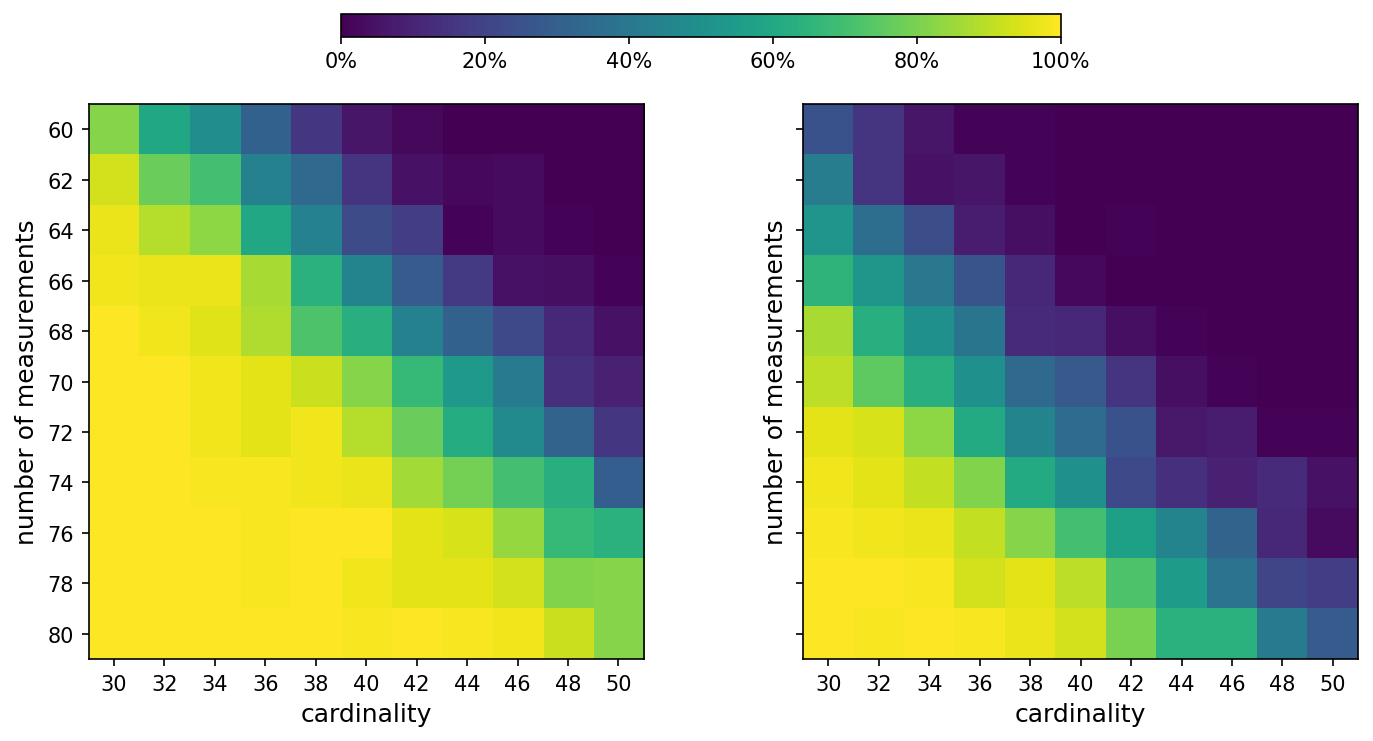

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), dpi=150, sharey=True,
                         gridspec_kw={'wspace': 0.05})

im1 = axes[0].imshow(probabilities_noncvx, interpolation="none")
axes[0].set_xticks(range(len(k))); axes[0].set_xticklabels(k)
axes[0].set_yticks(range(len(m))); axes[0].set_yticklabels(m)
axes[0].set_xlabel("cardinality", fontsize=12)
axes[0].set_ylabel("number of measurements", fontsize=12)

im2 = axes[1].imshow(probabilities_cvx, interpolation="none")
axes[1].set_xticks(range(len(k))); axes[1].set_xticklabels(k)
axes[1].set_yticks(range(len(m))); axes[1].set_yticklabels(m)
axes[1].set_xlabel("cardinality", fontsize=12)
axes[1].set_ylabel("number of measurements", fontsize=12)

# Shared colorbar on top
# Shared colorbar placed in a fixed figure slot (doesn't change subplot sizes)
cax = fig.add_axes([0.3, 0.94, 0.4, 0.03])  # [left, bottom, width, height] in figure coords
cbar = fig.colorbar(im1, cax=cax, orientation='horizontal')
cbar.ax.xaxis.set_major_formatter(PercentFormatter(xmax=1.0))
fig.subplots_adjust(top=0.85)
plt.savefig("figures/sparse_recovery_colorbar_top.pdf")